In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!cp /content/drive/MyDrive/Colab_Notebooks_Extended_Ana/toolbox_gdrive.py /content

Mounted at /content/drive


In [2]:
import sys
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import astropy.units as u
import astropy.utils as utils
from astropy.nddata import Cutout2D
import numpy as np
from operator import itemgetter, attrgetter
from scipy.optimize import curve_fit
from prettytable import PrettyTable

import toolbox_gdrive


# First, we load a cosmic-ray background model

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 51544.500000 from DATE-OBS.
Set MJD-END to 51547.500000 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 51544.500000 from DATE-OBS.
Set MJD-END to 51547.500000 from DATE-END'.


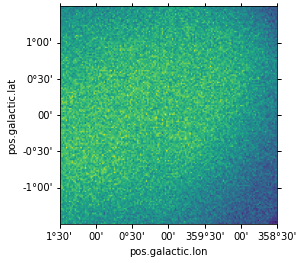

In [3]:
folder_dict = toolbox_gdrive.simulation_dict()

folder_name = folder_dict['bkg']
# load the background map from the file
bkg_wcs, bkg_image_data_reduced = toolbox_gdrive.load_image(folder_name)

ax_bkg_map = plt.subplot(projection=bkg_wcs.dropaxis(2))
ax_bkg_map.imshow(bkg_image_data_reduced[:,:])
plt.show()

# Next, we load a simulation of a point-like source emission (with background contamination)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 51544.500000 from DATE-OBS.
Set MJD-END to 51547.500000 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 51544.500000 from DATE-OBS.
Set MJD-END to 51547.500000 from DATE-END'.


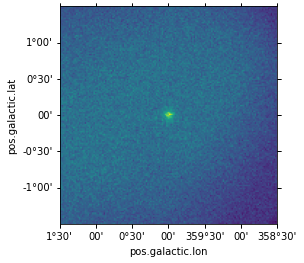

In [4]:
folder_name = folder_dict['r0p005']
# load the gamma-ray source + background map from the file
point_src_wcs, point_src_image_data_reduced = toolbox_gdrive.load_image(folder_name)

ax_src_map = plt.subplot(projection=point_src_wcs.dropaxis(2))
ax_src_map.imshow(point_src_image_data_reduced[:,:])
plt.show()

# Remove the background from the source emission

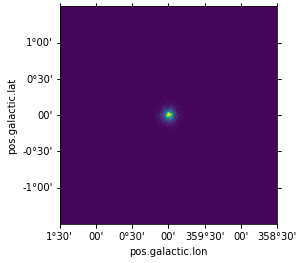

In [5]:
# prepare an empty map
point_src_image_data_residual = np.full((bkg_image_data_reduced.shape),0.)
# add the gamma-ray source + background map
point_src_image_data_residual += point_src_image_data_reduced
# subtract the background map
point_src_image_data_residual -= bkg_image_data_reduced

ax_src_map = plt.subplot(projection=point_src_wcs.dropaxis(2))
ax_src_map.imshow(point_src_image_data_residual[:,:])
plt.show()

# Here we plot the point-spread function (PSF). 
# This is the function that we use to describe the radial profile of a point-like source.
# You can change the values of the parameters, sigma and gamma, and see how your change affects the curve.

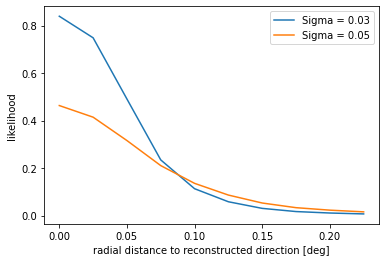

In [16]:
radial_axis, test1_function = \
toolbox_gdrive.plot_king_function(bkg_wcs,bkg_image_data_reduced,par_sigma=0.03,par_gamma=2.0,par_A=0.02)
radial_axis, test2_function = \
toolbox_gdrive.plot_king_function(bkg_wcs,bkg_image_data_reduced,par_sigma=0.05,par_gamma=2.0,par_A=0.02)

plt.plot(radial_axis,test1_function,label='Sigma = 0.03')
plt.plot(radial_axis,test2_function,label='Sigma = 0.05')
plt.xlabel('radial distance to reconstructed direction [deg]')
plt.ylabel('likelihood')
plt.legend(loc='best')
plt.show()

# Fit the PSF to the point-like source data and find the parameters for a point-like source.

In [7]:
init_sigma, init_gamma = toolbox_gdrive.load_psf_param(point_src_wcs,point_src_image_data_residual,bkg_image_data_reduced)
print ('init_sigma = %0.4f, init_gamma = %0.4f'%(init_sigma,init_gamma))

init_sigma = 0.0356, init_gamma = 2.0009


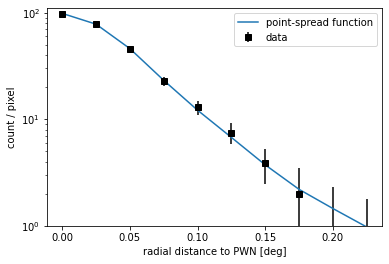

In [8]:
# Fit the point-like source and compare the fit function to the data.
# The values for sigma anfd gamma are fixed to init_sigma and init_gamma.

radial_axis, data_points, data_errors = toolbox_gdrive.get_radial_profile(point_src_wcs,point_src_image_data_residual,bkg_image_data_reduced)
radial_axis, PSF_function = \
toolbox_gdrive.point_src_fit(point_src_wcs,point_src_image_data_residual,bkg_image_data_reduced,init_sigma,init_gamma)

plt.errorbar(radial_axis,data_points,data_errors,color='k',marker='s',ls='none',label='data')
plt.plot(radial_axis,PSF_function,label='point-spread function')
plt.xlabel('radial distance to PWN [deg]')
plt.ylabel('count / pixel')
plt.ylim(bottom=1.)
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [9]:
point_chi2 = 0.
for x in range(0,len(data_points)):
    data = data_points[x]
    fit_func = PSF_function[x]
    error = data_errors[x]
    chi2 = pow((data-fit_func)/error,2)
    point_chi2 += chi2
print ('point_chi2 = %0.2f'%(point_chi2))

point_chi2 = 0.89


# Load a simulation data of an extended source. You can change the extend-source file for a different radius:
# (0.010, 0.015, 0.020, 0.025, 0.030, 0.035, 0.040)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
Set MJD-OBS to 51544.500000 from DATE-OBS.
Set MJD-END to 51547.500000 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 51544.500000 from DATE-OBS.
Set MJD-END to 51547.500000 from DATE-END'.


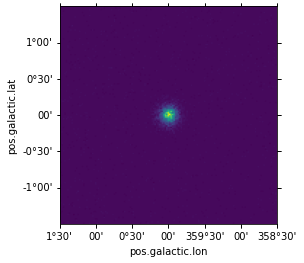

In [10]:
# change the string here to use a different source radius
#folder_name = folder_dict['r0p010']
#folder_name = folder_dict['r0p015']
#folder_name = folder_dict['r0p020']
#folder_name = folder_dict['r0p025']
#folder_name = folder_dict['r0p030']
#folder_name = folder_dict['r0p035']
folder_name = folder_dict['r0p040']
extend_src_wcs, extend_src_image_data_reduced = toolbox_gdrive.load_image(folder_name)

# obtaib the new source map and remove the background
extend_src_image_data_residual = np.full((bkg_image_data_reduced.shape),0.)
extend_src_image_data_residual += extend_src_image_data_reduced
extend_src_image_data_residual -= bkg_image_data_reduced

ax_src_map = plt.subplot(projection=extend_src_wcs.dropaxis(2))
ax_src_map.imshow(extend_src_image_data_residual[:,:])
plt.show()

# Fit the function to the extended-source data and compare the parameters to the point-like source result.

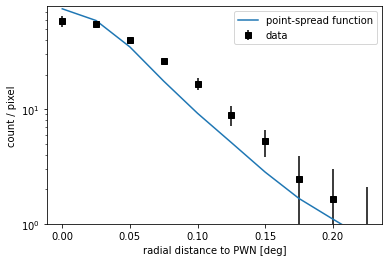

In [11]:
# Fit the PSF to the new source of a larger radius and assume an extended source

radial_axis, data_points, data_errors = toolbox_gdrive.get_radial_profile(extend_src_wcs,extend_src_image_data_residual,bkg_image_data_reduced)
radial_axis, PSF_function = \
toolbox_gdrive.point_src_fit(extend_src_wcs,extend_src_image_data_residual,bkg_image_data_reduced,init_sigma,init_gamma)

plt.errorbar(radial_axis,data_points,data_errors,color='k',marker='s',ls='none',label='data')
plt.plot(radial_axis,PSF_function,label='point-spread function')
plt.xlabel('radial distance to PWN [deg]')
plt.ylabel('count / pixel')
plt.ylim(bottom=1.)
plt.yscale('log')
plt.legend(loc='best')
plt.show()


In [12]:
extend_chi2 = 0.
for x in range(0,len(data_points)):
    data = data_points[x]
    fit_func = PSF_function[x]
    error = data_errors[x]
    chi2 = pow((data-fit_func)/error,2)
    extend_chi2 += chi2
print ('extend_chi2 = %0.2f'%(extend_chi2))

extend_chi2 = 54.82


# If your output above shows "point_chi2 - extend_chi2 > 25", the source extension is significantly larger than the telescope angular resolution and can be resolved!